# Centrale Krachten

## Nuttige Tools

### Newton-Rhapson methode

De Newton-Rhapson is een iteratieve methode voor het vinden van nulpunten 
waarbij de vorige gok geüpdatet wordt via

\begin{equation}
    x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}
\end{equation}

en stopt vanaf een voooropgestelde nauwkeurigheid is bereikt.

In [10]:
# Nodig voor symbolische functies
from sympy import Symbol, Derivative

def newton_rhapson(f, xval=0, tol=1e-12, maxiter=50):
    """Geeft np.nan terug (not a number) indien geen nulpunt is gevonden"""
    
    if len(f.free_symbols) != 1:
        raise ValueError('Functie van meer dan 1 variabele ingegeven')
    x = f.free_symbols.pop()  # De variabele van de functie
    df = Derivative(f).doit()  # Het symbolisch afleiden van de functie
    
    xprev, iterations = None, 0
    try:
        while iterations == 0 or abs(xprev - xval) > tol:
            xval, xprev = xval - f.subs(x, xval).evalf() / df.subs(x, xval).evalf(), xval
            iterations += 1
            if iterations > maxiter:
                return np.nan
        return float(xval)
    
    except OverflowError:
        return np.nan

We testen nu onze rudimentaire Newton-Rhapson methode uit voor het zoeken van 
de nulpunten van een parabool.

In [11]:
x = Symbol('x', real=True)
f = (x + 1) * (x - 4)
print(f'Eerste nulpunt: {newton_rhapson(f, xval=0):.2f}')
print(f'Tweede nulpunt: {newton_rhapson(f, xval=10):.2f}')

Eerste nulpunt: -1.00
Tweede nulpunt: 4.00


We merken dat het nulpunt dat Newton-Rhapson vindt afhangt van de initiële 
waarde.

## Potentialen

We werken symbolisch via SymPy. De Yukawa-potentiaal en de angulaire kinetische
energie wordt gedefinieerd.

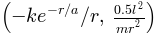

In [12]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

from sympy import symbols, exp, nsolve, init_printing, sqrt, Derivative, Eq
import matplotlib.pyplot as plt
pltm=10  # plot scaling, for addapting the plotting to your screen size

plt.rc('figure', figsize=(pltm, pltm))
plt.rc('font', size=pltm * 3)
init_printing()

r, a, k, m, l, E  = symbols('r,a,k,m,l,E', real=True)
Yukawa = -k / r * exp(-r / a) 

# Angulaire kinetische energie
T_angulair = 1/2 * l ** 2 / (m * r ** 2)

# De effectieve potentiaal
Veff = T_angulair + Yukawa

Yukawa, T_angulair

De cirkelvoorwaarde wordt gegeven door de extremale punten van de effectieve 
potentiaal (nulpunten van de afgeleide):

In [13]:
f_cirkel = Eq(Derivative(Veff, r).doit(), 0)

Dit is dezelfde voorwaarde als afgeleid in oefeningenreeks 5. 
We kiezen de systeemvariabelen $(a, m, k)$ gelijk aan 1 en kiezen het 
impulsmoment zodanig dat er een cirkelbaan is op $r = 3$. De positieve
oplossing van het impulsmoment kan gekozen worden zonder verlies van
algemeenheid.

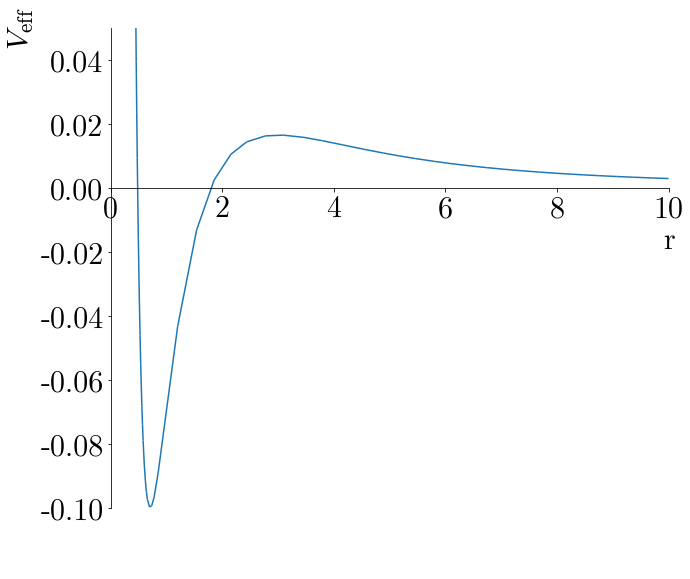

In [14]:
from sympy import plot
# variabelen: m = 1, a = 1, k = 1
var = {m: 1., a: 1., k: 1.}

# Invullen van variabelen in voorwaarde cirkelbaan
f_cirkel = f_cirkel.subs(var)
# Oplossen naar l voor r_cirkel=3
var[l] = abs(nsolve(f_cirkel.subs(r, 3), l, 1))

plot(Veff.subs(var), xlim=(0, 10), ylim=(-0.12, 0.05), xlabel='r', ylabel=r'$V_\mathrm{eff}$')

Grafisch zien we dat het extremum bij $r = 3$ een onstabiele cirkelbaan zal 
opleveren **(rmaximum)** terwijl er ook een tweede cirkelbaan aanwezig is die 
stabiel is **(minimum)**.

In [15]:
r_onstabiel = nsolve(f_cirkel.subs(var), r, 2.5)
r_stabiel = nsolve(f_cirkel.subs(var), r, 0.5)
r_onstabiel, r_stabiel

## Berekenen van de baan

De centrale krachtproblemen die we vinden in de lessen worden getypeerd door
bewegingsvergelijkingen van de volgende vorm:
 
\begin{align}
    m\ddot{r} &= -\frac{\partial V_\mathrm{eff}}{\partial r}\\
    l &= m r^2 \dot{\phi}
\end{align}

In plaats om de eerste bewegingsvergelijking voor $r$ te gebruiken, is het 
eenvoudiger om met behoud van energie te werken:

\begin{align}
    E &= T + V\\
    E &= \frac{1}{2} m \left(\dot{r}^2 + r^2\dot{\phi}^2\right) + V(r)\\
    E &= \frac{1}{2} m \dot{r}^2 + \frac{1}{2} \frac{l^2}{mr^2} + V(r)\\
\end{align}

In dit geval bekomen we dus de volgende twee differentiaalvergelijkingen:

\begin{align}
    \dot{\phi} &= \frac{l}{mr^2}\\
    \dot{r} &= \pm \sqrt{\frac{2}{m}\left(E - \frac{1}{2} \frac{l^2}{mr^2} - V(r)\right)}
    = \pm \sqrt{\frac{2}{m}\left(E - V_\mathrm{eff}(r)\right)}
\end{align}

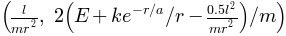

In [16]:
phidot = l / (m * r ** 2)
rdot_sq = 2 / m * (E - Veff)
phidot, rdot_sq

### De Euler-methode

Indien een initiële $r$ en $\phi$ is gekozen, kunnen deze
differentiaalvergelijkingen gebruikt worden om het systeem te evolueren in de
tijd. We gebruiken hier de
[Euler-methode](https://nl.wikipedia.org/wiki/Methode_van_Euler), dit is de
simpelste methode om gewone differentiaalvergelijkingen numeriek op te lossen.
Accuratere methoden bestaan (zoals bijvoorbeeld
[Runge-Kutta](https://nl.wikipedia.org/wiki/Runge-Kuttamethode)), maar voor
deze simpele problemen volstaat de Euler-methode. De Euler-methode is gegeven
door:

\begin{equation}
    x(t + Δt) \approx x(t) + \dot{x}(t)Δt
\end{equation}

Hoe kleiner $Δt$ gekozen, hoe accurater de verkregen baan.

In [17]:
def Euler(rdot_sq, phidot, r_start, r_teken=1., phi_start=0, steps=1000, dt=0.1):
    # Zeker zijn dat de effectieve potentiaal op de beginpositie kleiner is 
    # dan de totale energie van het systeem.
    assert rdot_sq(r_start) > 0

    r_array = np.zeros(steps)
    phi_array = np.zeros(steps)
    r_array[0] = r_start
    phi[0] = phi_sttart
    for step in range(steps - 1):
        # Euler-update: bereken de volgende waarde voor r
        r[step + 1] = r[step] + r_teken * dt * np.sqrt(rdot_sq(r[step]))
        if rdot_sq(r[step + 1]) < 0:
            r[step + 1] = r[step]
            r_teken *= -1
        # Euler-update: bereken de volgende waarde voor phi
        phi[step + 1] = phi[step] + dt * l / (m * r[step] ** 2)
    return r, phi

$r$ en $\phi$ worden respectievelijk op `r_start` en `phi_start` 
geïnitialiseerd. Het initieel teken van $\dot{r}$ kan ook gespecificeerd worden 
(via `r_teken`) aangezien deze niet bepaald wordt door de 
bewegingsvergelijkingen.

Het updaten van $\phi(t)$ gebeurt door een simpele Euler-update. Bij het 
updaten van $r(t)$ moet er nog rekening gehouden worden dat het argument 
onder wortel in

\begin{align}
    \dot{r} &= \pm \sqrt{\frac{2}{m}\left(E - - V_\mathrm{eff}(r)\right)}
\end{align}

negatief kan worden na een update doordat $V_\mathrm{eff} > E$.
 
Deze situatie is fysisch niet mogelijk, we zullen nooit door de
potentiaal-barrière breken. Op de barrière zal $\dot{r} = 0$ worden en daarna
veranderen van teken. Dat er hier door de potentiaal-barrière gebroken wordt is
slechts een artifact door de eindige tijdsstappen.

We moeten hiervoor dus corrigeren. We corrigeren door:

```python
if Veff(r[step + 1]) > E:
    r[step + 1] = r[step]
    r_teken *= -1
```

Indien we de potentiaal-barrière zouden doorbreken, zetten we het deeltje terug
op zijn vorige positie $r$ en veranderen we het teken van $\dot{r}$. Dit is
slechts een ruwe correctie, maar accuraat genoeg indien kleine tijdsstappen
genomen worden.
 

## Stabiele Cirkelbaan

We bestuderen eerst de stabiele cirkelbaan. De stabiele cirkelbaan wordt
bevindt zicht op ($\dot{r} = 0 → V_\mathrm{eff} = E$):

In [ ]:
E_stabiel = Veff.subs(var).subs(r, r_stabiel).evalf()
print(f'r={r_stabiel}, E={E_stabiel}')

We illustreren de stabiliteit van deze cirkelbaan door de
bewegingsvergelijkingen expliciet op te lossen met de Euler-methode voor een
energie licht afwijkend van $E_\mathrm{stabiel}$.

In [ ]:
t_array, r_array, phi_array = calc_path(r_init, E, l, sign, t_tot, t_steps)
fig = plt.figure(figsize=(11,15))
ax = plt.subplot(321, projection = 'polar')
ax.set_ylim(0, 8)
ax.plot(phi_array, r_array)
ax = plt.subplot(322)
ax.set_title(r'$r_{init} = r_{cirkel}$', loc='left')
ax.plot(t_array, r_array)
ax.set_xlabel(r"time $t$")
ax.set_ylabel(r"$r$")